In [9]:
import os
import random

from collections import OrderedDict
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box, compute_ts_road_map

from anchors import get_bbox_gt, batched_coor_threat_updated


from resnet import resnet18
from obj_model import BoundingBox

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
# construct anchor boxes
def get_anchor_boxes(scaleX=[100, 70, 50, 20], scaleY=[25, 20, 15, 5]):
    widths = torch.tensor(scaleX)
    heights = torch.tensor(scaleY)
    ref_boxes = []
    for x in range(800):
        for y in range(800):
            x_r = widths + x
            y_r = heights + y
            x_l = torch.tensor([x, x, x, x])
            y_l = torch.tensor([y, y, y, y])
            x_r = x_r.unsqueeze(0)
            y_r = y_r.unsqueeze(0)
            x_l = x_l.unsqueeze(0)
            y_l = y_l.unsqueeze(0)
            ref_box = torch.cat((x_l, y_l, x_r, y_r))
            ref_box = ref_box.permute((1,0))
            ref_boxes.append(ref_box)

    anchor_boxes = torch.stack(ref_boxes).view(-1,4).type(torch.double)
    
    return anchor_boxes

In [39]:
def nms(boxes, scores, iou_threshold):
    # type: (Tensor, Tensor, float)
    """
    Performs non-maximum suppression (NMS) on the boxes according
    to their intersection-over-union (IoU).
    NMS iteratively removes lower scoring boxes which have an
    IoU greater than iou_threshold with another (higher scoring)
    box.
    Parameters
    ----------
    boxes : Tensor[N, 4])
        boxes to perform NMS on. They
        are expected to be in (x1, y1, x2, y2) format
    scores : Tensor[N]
        scores for each one of the boxes
    iou_threshold : float
        discards all overlapping
        boxes with IoU > iou_threshold
    Returns
    -------
    keep : Tensor
        int64 tensor with the indices
        of the elements that have been kept
        by NMS, sorted in decreasing order of scores
    """
    return torch.ops.torchvision.nms(boxes, scores, iou_threshold)



def batched_coor_threat_updated(ite, predicted_offsets, anchor_boxes, target, gt_classes, batch_sz, nms_threshold=0.1, plot=False):
  # predicted offsets, target_offests, coor_in_meter
    batch_coor = []
    batched_threat_sum=0
    original_anchor = anchor_boxes.clone()
    original_predicted_offsets = predicted_offsets.clone()
    original_gt_classes = gt_classes.clone()

    for i in range(batch_sz):
        anchor_boxes = original_anchor
        predicted_offsets = original_predicted_offsets[i]
        if i == 0:
          cur_target = torch.from_numpy(target[0])
        else:
          cur_target = torch.from_numpy(target[1])
    
        gt_classes = original_gt_classes[i]

        inds = (gt_classes != 0)
        anchor_boxes = anchor_boxes[inds]
        predicted_offsets = predicted_offsets[inds]
        gt_classes = gt_classes[inds]


        delta_x = predicted_offsets[:,0]
        delta_y = predicted_offsets[:,1]
        delta_scaleX = predicted_offsets[:,2]
        delta_scaleY = predicted_offsets[:,3]

        gt_widths = anchor_boxes[:, 2] - anchor_boxes[:, 0]
        gt_heights = anchor_boxes[:, 3] - anchor_boxes[:, 1]
        gt_center_x = anchor_boxes[:, 0] + 0.5 * gt_widths
        gt_center_y = anchor_boxes[:, 1] + 0.5 * gt_heights

        ex_width = gt_widths / torch.exp(delta_scaleX)
        ex_height = gt_heights / torch.exp(delta_scaleY)
        ex_center_x = gt_center_x - delta_x*ex_width
        ex_center_y = gt_center_y - delta_y*ex_height

        ex1 = ex_center_x - 0.5*ex_width
        ex2 = ex_center_x + 0.5*ex_width
        ey1 = ex_center_y - 0.5*ex_height
        ey2 = ex_center_y + 0.5*ex_height


        pred_boxes = torch.cat([ex1.unsqueeze(0), ey1.unsqueeze(0), ex2.unsqueeze(0), ey2.unsqueeze(0)], dim=0).permute(1,0)
        pred_boxes = pred_boxes.type(torch.float32)
        gt_classes = gt_classes.type(torch.float32)
        cur_target = cur_target.type(torch.float32)
   
        inds = nms(pred_boxes, gt_classes, nms_threshold)
        pred_boxes = pred_boxes[inds]
        coordinate_list = []

        for box in pred_boxes:
            x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
            x1 = (x1-400)/10
            x2 = (x2-400)/10
            y1 = (y1-400)/-10
            y2 = (y2-400)/-10
            width = abs(x1 - x2)
            height = abs(y1 - y2)
            coordinate_list.append(torch.tensor([x2, x2, x1, x1, y2, y1, y2, y1]).view(-1, 4))
            
        coordinate_list = torch.stack(coordinate_list)
        
        
        print('batch {}'.format(i))
        print(coordinate_list)
        print('current Threat Score {}'.format( compute_ats_bounding_boxes(coordinate_list, cur_target) ))
        
        batched_threat_sum += compute_ats_bounding_boxes(coordinate_list, cur_target)
        batch_coor.append(coordinate_list)
        #visActual(cur_target, ite,i)
    return batch_coor, batched_threat_sum


In [30]:
def get_targets(target, sample):
    device = 'cpu'
    map_sz = 800
    batched_preds = []
    batched_offsets = []
    for t, s in zip(target, sample):
        bboxes = t['bounding_box'].to(device)
        gt_classes, gt_offsets = get_bbox_gt(bboxes, t['category'].to(device), get_anchor_boxes().to(device), map_sz, device)
        batched_preds.append(gt_classes)
        batched_offsets.append(gt_offsets)

    class_targets = torch.stack(batched_preds)
    box_targets = torch.stack(batched_offsets)

    return class_targets, box_targets

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [5]:
labeled_scene_index = np.arange(106, 134)

train_index = np.arange(106,108)
val_index = np.arange(128,130)

In [7]:
transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=train_index,
    transform=transform,
    extra_info=False
    )

labeled_valset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=val_index,
    transform=transform,
    extra_info=False
    )

trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [10]:
model = BoundingBox().double().to(device)

In [13]:
model.load_state_dict(torch.load('../code/PT_FILES/bbox_1epoch.pt', map_location=device))

<All keys matched successfully>

In [14]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.transpose(0,1).numpy()[0] * 10 + 400, -point_squence.transpose(0,1).numpy()[1] * 10 + 400, color=color)

# The center of image is 400 * 400

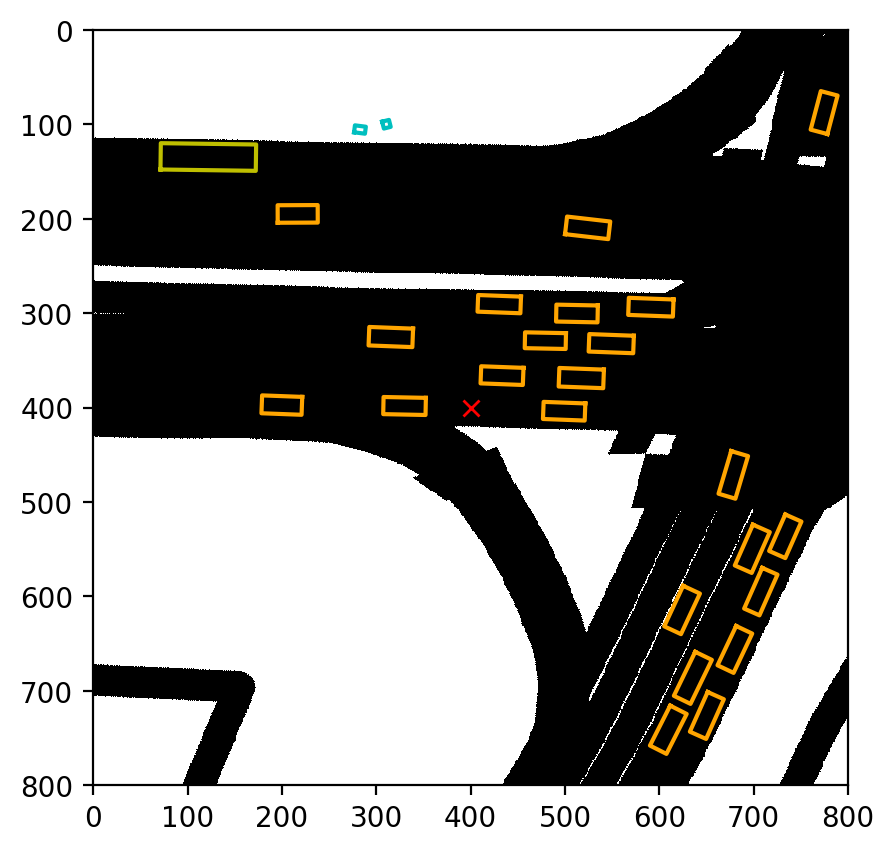

In [32]:
sample, target, road_image = iter(valloader).next()

fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])

In [33]:
model.eval()

BoundingBox(
  (encoder): ResNet(
    (conv1): Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [34]:
s = torch.stack(sample).to('cpu').double()

out_pred, out_bbox = model(s)
class_target, box_target = get_targets(target, sample)

In [35]:
print(out_pred.shape)
print(out_bbox.shape)

print(class_target.shape)
print(box_target.shape)

torch.Size([1, 36, 800, 800])
torch.Size([1, 16, 800, 800])
torch.Size([1, 2560000])
torch.Size([1, 2560000, 4])


In [36]:
out_bbox = out_bbox.view(out_bbox.shape[0], -1, 4)

In [37]:
out_bbox.shape

torch.Size([1, 2560000, 4])

In [40]:
final_coor, batched_threat_sum = batched_coor_threat_updated(_, out_bbox, get_anchor_boxes(), [target[0]['bounding_box'].numpy()], class_target, 1, nms_threshold=0.1, plot=False)

RuntimeError: No such operator torchvision::nms

In [45]:
!python3 -m torch.utils.collect_env

PyTorch version: 1.5.0
Is debug build: No
CUDA used to build PyTorch: None

OS: Mac OSX 10.15.4
GCC version: Could not collect
CMake version: Could not collect

Python version: 3.7
Is CUDA available: No
CUDA runtime version: No CUDA
GPU models and configuration: No CUDA
Nvidia driver version: No CUDA
cuDNN version: No CUDA

Versions of relevant libraries:
[pip3] numpy==1.16.3
[pip3] torch==1.5.0
[pip3] torchvision==0.6.0
[conda] Could not collect
